# Load the data

In [1]:
# Import necessary packages
using DrWatson
using JLD2

# Activate the project environment
@quickactivate :FlowComplexity

# Define the file path
file_path = joinpath("./data.t=100", "data.jld2")

# Load the data from the specified file
@load file_path sim_array

1-element Vector{Symbol}:
 :sim_array

# Show time series for all chemostats of simulation no. X

In [ ]:
using DataFrames

sim_no = 90
sim = sim_array[sim_no]
nchem = 9

# Define the array that will hold our population time series
max_t = Int(sim.total_time)
nspecies = 10
pop_array = zeros(Int, nchem, max_t, nspecies)

# Populate the population array
time_series_df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)
for i in 1:nchem
    for j in 1:max_t
        for k in 1:nspecies
            filtered_time_series_df = filter(row -> row[:reactor] == i && row[:time] == j && row[:variable] == string(k), time_series_df)
            if nrow(filtered_time_series_df) > 0
                pop_array[i, j, k] = filtered_time_series_df[1, :value]
            end
        end
    end
end

using Plots, FileIO

# Create a 3x3 grid plot
plot_grid = plot(layout = (3, 3))

# Loop over each subplot
for i in 1:nchem
    # Extract the time series data for the i-th plot
    time_series_data = pop_array[i, :, :]
    
    # Create a subplot for each species in the time series
    p = plot()
    for j in 1:nspecies
        plot!(plot_grid[i], 1:max_t, time_series_data[:, j], label = "Species $j", legend = :none)
    end
end


display(plot_grid)

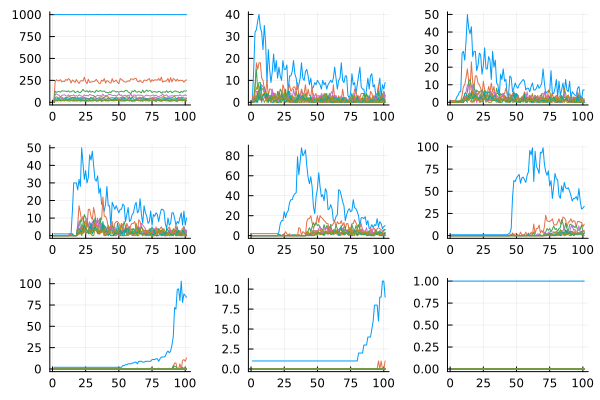

In [108]:
using DataFrames, Plots, FileIO

sim_no = 9
sim = sim_array[sim_no]
nchem = 9

# Define the array that will hold our population time series
max_t = Int(sim.total_time) + 1 # our sim goes to 0...100 so index has to go 1...101
nspecies = 10
pop_array = zeros(Int, nchem, max_t, nspecies)

# Convert the time series to a DataFrame
time_series_df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)

# Populate the population array using efficient DataFrame operations
for row in eachrow(time_series_df)
    
    i = Int(row[:reactor])
    j = Int(row[:time]) + 1 # indexing starts at 1
    k = parse(Int, row[:variable]) # to account for absent data (i.e., zero)
    if k > nspecies
        continue
    end
    # println(row)
    # println("i=$i j=$j k=$k")
    pop_array[i, j, k] = row[:value]
end

# Create a 3x3 grid plot
plot_grid = plot(layout = (3, 3))

# Loop over each subplot
for i in 1:nchem
    # Extract the time series data for the i-th plot
    time_series_data = pop_array[i, :, :]
    
    # Create a subplot for each species in the time series
    p = plot()
    for j in 1:nspecies
        plot!(plot_grid[i], 1:max_t, time_series_data[:, j], label = "Species $j", legend = :none)
    end
end

display(plot_grid)

# Plot the Std(M) vs $k_d$ 

## (i.e., the std of monomers vs the outflow)

In [86]:
using DataFrames, Plots, FileIO, Statistics

first_sim = sim_array[1]
nsims = 100
nchem = 9
nspecies = 10
t = 100

# Define the array that will hold our data
pops = zeros(Float64, nsims, nchem, nspecies)

# Loop over all the simulations
for i in 1:100
    sim = sim_array[i]
    df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)
    df = filter(row -> row[:time] == t, df)

    for j in 1:nchem
        df_reactor = filter(row -> row[:reactor] == j, df)

        for k in 1:nspecies
            df_reactor_species = filter(row -> row[:variable] == string(k), df_reactor)
            if nrow(df_reactor_species) > 0
                pops[i, j, k] = df_reactor_species[1, :value]      
            end
        end
    end
end

In [87]:
display(pops[2,:,:])

9×10 Matrix{Float64}:
 1000.0  285.0  113.0  64.0  52.0  41.0  32.0  22.0  12.0  17.0
    5.0    2.0    2.0   3.0   0.0   1.0   0.0   0.0   0.0   0.0
   20.0   11.0    5.0   3.0   4.0   2.0   3.0   3.0   0.0   1.0
   73.0   14.0   12.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
    2.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0

In [88]:
stds = zeros(Float64, nsims, nspecies)

for i in 1:100
    for j in 1:nspecies
        stds[i, j] = std(pops[i, :, j])
        # stds = dropdims(stds, dims=2)
    end
end

display(stds)

100×10 Matrix{Float64}:
 330.536  83.8502  40.5487  25.8978  19.2209  …   6.59124  4.97494  4.31406
 330.022  94.0279  37.0911  21.1233  17.2176      7.27629  4.0      5.63471
 328.187  82.6904  37.3233  26.3201  17.7889      9.26013  2.82843  7.4963
 327.524  87.8977  37.5733  25.1667  20.1067     10.8972   6.91014  4.53995
 329.037  84.7349  34.5652  20.7351  21.0858      5.93951  7.12     8.23779
 329.273  73.2918  33.5439  28.1134  23.0711  …   7.90569  5.25463  5.76869
 328.226  79.4512  46.6193  26.1905  20.3961      7.18409  4.64878  6.03002
 327.938  80.2923  39.6583  21.1785  14.9332      7.81025  8.55538  5.52268
 327.542  83.8597  43.0552  25.0006  16.4249      6.86982  7.85812  5.2915
 327.428  88.5844  35.602   24.1661  18.5749      8.4179   5.87603  5.15051
   ⋮                                          ⋱                     
 331.063  75.1129  34.6811  27.4763  16.7266      7.12     4.1833   6.30035
 330.994  82.1423  41.1798  20.137   16.9337      8.59425  9.39415  4.226

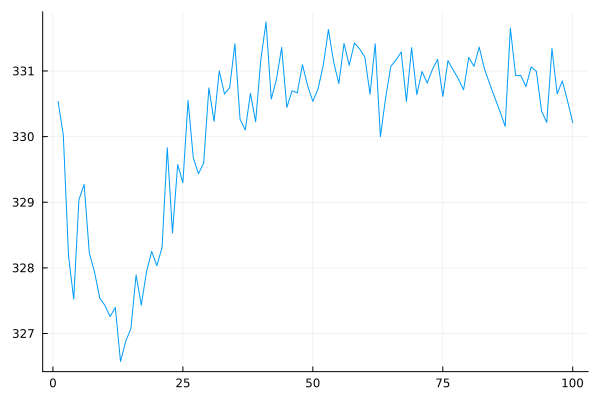

In [107]:
p = plot()

for i in 1:1
    plot!(p, 1:100, stds[:, i], legend= :none)
end

display(p)

In [61]:
display(stds)

100×10 Matrix{Float64}:
 439.012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 436.966  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 397.259  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 368.61   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 371.182  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 348.543  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 347.241  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 346.844  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 327.542  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 346.221  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   ⋮                          ⋮                   
 350.775  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 330.994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 330.391  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 330.217  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 331.343  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 330.652  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 330.849  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 350.13

In [60]:
std([1000,10,20,50,1,0,0,0,0])

330.37117173129855

In [105]:
mu = zeros(Float64, nsims, nspecies)

for i in 1:100
    for j in 1:nspecies
        mu[i, j] = mean(pops[i, :, j])
        # stds = dropdims(stds, dims=2)
    end
end

display(mu)

100×10 Matrix{Float64}:
 119.667  30.8889  15.2222  10.2222   …  5.22222  2.77778  2.0      2.11111
 122.222  34.6667  14.6667   7.77778     3.88889  2.77778  1.33333  2.0
 127.0    29.7778  13.5556  10.0         5.0      3.33333  1.33333  3.22222
 129.222  34.3333  15.3333  10.1111      3.88889  4.0      2.66667  2.11111
 123.889  31.3333  13.0      7.77778     3.88889  2.55556  3.22222  3.11111
 122.889  26.7778  12.7778  10.1111   …  3.55556  3.0      2.11111  2.55556
 125.889  30.6667  17.8889  11.7778      4.22222  2.88889  2.11111  3.11111
 127.333  30.1111  15.4444   7.55556     5.22222  3.33333  3.22222  3.0
 129.222  32.7778  16.3333   9.44444     5.0      3.22222  3.33333  2.0
 128.556  34.2222  14.6667   9.66667     3.0      3.88889  2.44444  2.55556
   ⋮                                  ⋱                             
 117.444  27.7778  12.5556  10.7778      3.55556  3.22222  2.0      2.22222
 117.667  30.1111  15.4444   7.33333     3.22222  3.11111  4.0      1.88889
 119.22

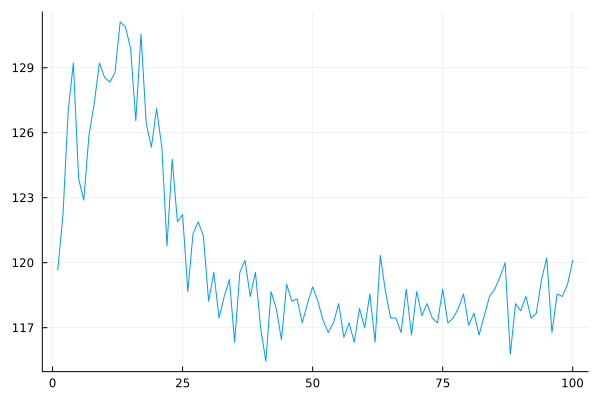

In [106]:
p = plot()

for i in 1:1
    plot!(p, 1:100, mu[:, i], legend= :none)
end

display(p)